# ML4DS - Multi Model Method

## 1.0 Open train file

In [ ]:
TRAINING_DATA = 'src/train.csv'

In [ ]:
import pandas as pd

df = pd.read_csv(TRAINING_DATA)
df

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone
0,2013,1,domestic,0,MOGV36480546611521,Installation_zone 1
1,2013,1,industrial,5,BECS02817768252637,Installation_zone 2
2,2013,1,domestic,6,VRFW65577141436242,Installation_zone 2
3,2013,1,domestic,1,QLLI18662653137621,Installation_zone 2
4,2013,1,domestic,13,HYUO61823402850645,Installation_zone 2
...,...,...,...,...,...,...
329970,2020,12,domestic,0,ZSOE03393580274296,Installation_zone 2
329971,2020,12,rural domestic,0,RVZG94535208799772,Installation_zone 47
329972,2020,12,rural domestic,0,DWGA69725679861554,Installation_zone 7
329973,2020,12,rural domestic,0,VJDC45865594518045,Installation_zone 32


### 1.1 Creating the consumer type group

In [ ]:
classes_to_group = {'rural commercial', 'construction', 'low income families', 'rural expansion'}
df['Consumer_type_group'] = df['Consumer_type'].replace(classes_to_group, 'grouped_class')

df['Consumer_type_group'].value_counts()

Consumer_type_group
domestic          236167
rural domestic     63086
industrial         21057
grouped_class       9665
Name: count, dtype: int64

### 1.2 Creating the Installation zone group

In [ ]:
def assign_groups(installation_zone):
    if installation_zone in [1, 2]:
        return 1
    elif installation_zone in [3]:
        return 2
    elif installation_zone in [4]:
        return 3
    elif installation_zone in [29, 35]:
        return 4
    else:
        return 5

df['Installation_zone'] = df['Installation_zone'].str.extract('(\d+)').astype(int)
df['Installation_zone_group'] = df['Installation_zone'].apply(assign_groups)

# df with consumer type in row, group in the column and the count of each group in the intersection
pd.crosstab(df['Consumer_type_group'], df['Installation_zone_group'])

Installation_zone_group,1,2,3,4,5
Consumer_type_group,,,,,
domestic,114461,58190,63486,0,30
grouped_class,3054,2902,557,1812,1340
industrial,9671,5197,6020,11,158
rural domestic,0,23,18,437,62608


## 2.0 Preprocessing for training

In [ ]:
# set random seed
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

### 2.1 Split into training and test rows

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_train

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone,Consumer_type_group,Installation_zone_group
43673,2013,12,domestic,3,GTWU88786537961127,2,domestic,1
139816,2017,1,domestic,6,TXYJ68235491595008,1,domestic,1
79289,2014,9,domestic,13,ZCAW05291666527137,2,domestic,1
260523,2019,8,domestic,10,CAQZ11415642108337,4,domestic,3
234725,2019,1,industrial,0,IBYG79062942157557,1,industrial,1
...,...,...,...,...,...,...,...,...
119879,2016,8,industrial,3,EWYZ09585248537065,3,industrial,2
259178,2019,7,rural domestic,10,XSXI58523967027569,36,rural domestic,5
131932,2016,11,domestic,2,CFUN91513615869213,2,domestic,1
146867,2017,3,domestic,2,TMYJ05922743991852,1,domestic,1


### 2.2 Removing zero consumption rows

In [ ]:
# remove zero Consumption values
df_train = df_train[df_train['Consumption'] > 0]

### 2.3 Removing outliers

In [ ]:
# remove outliers based on the Interquartile Range Method
def remove_outliers(group):
    Q1 = group['Consumption'].quantile(0.25)
    Q3 = group['Consumption'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    cleaned_group = group[(group['Consumption'] >= lower_bound) & (group['Consumption'] <= upper_bound)]

    return cleaned_group

df_train = df_train.groupby('Consumer_type_group').apply(remove_outliers).reset_index(drop=True)
df_train

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone,Consumer_type_group,Installation_zone_group
0,2013,12,domestic,3,GTWU88786537961127,2,domestic,1
1,2017,1,domestic,6,TXYJ68235491595008,1,domestic,1
2,2014,9,domestic,13,ZCAW05291666527137,2,domestic,1
3,2019,8,domestic,10,CAQZ11415642108337,4,domestic,3
4,2014,3,domestic,1,TBNK90322025808205,4,domestic,3
...,...,...,...,...,...,...,...,...
204917,2020,12,rural domestic,1,PGKS38902815101036,38,rural domestic,5
204918,2014,5,rural domestic,11,OCIE73113309066358,11,rural domestic,5
204919,2019,12,rural domestic,3,QGEB44943317230377,32,rural domestic,5
204920,2019,7,rural domestic,10,XSXI58523967027569,36,rural domestic,5


## 3.0 Training model 1 - Group Detection

### 3.1 Filtering columns

In [ ]:
features_training_1 = ['Month','Consumption','Installation_zone_group']
X_train_1 = df_train[features_training_1]
y_train_1 = df_train['Consumer_type_group']

df_train[features_training_1]

,Month,Consumption,Installation_zone_group
0,12,3,1
1,1,6,1
2,9,13,1
3,8,10,3
4,3,1,3
...,...,...,...
204917,12,1,5
204918,5,11,5
204919,12,3,5
204920,7,10,5


### 3.2 Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_1, y_train_1 = rus.fit_resample(X_train_1, y_train_1)

### 3.3 Fitting model 1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train_1, y_train_1)

KNeighborsClassifier(n_neighbors=9)

## 4.0 Training model 2 - Minor Types Detection

### 4.1 Filtering grouped_class

In [ ]:
df_train_2 = df_train[df_train.Consumer_type_group == 'grouped_class']
df_train_2

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone,Consumer_type_group,Installation_zone_group
151984,2019,3,rural expansion,9,YBGK23391271250637,14,grouped_class,5
151985,2018,5,rural commercial,8,VVEU13054131438984,2,grouped_class,1
151986,2013,5,rural commercial,9,VVEU13054131438984,2,grouped_class,1
151987,2020,8,low income families,4,HRWJ65202506858329,3,grouped_class,2
151988,2017,5,rural commercial,9,MBQJ22791550406629,2,grouped_class,1
...,...,...,...,...,...,...,...,...
157287,2017,5,rural commercial,8,KXGS75594456366682,35,grouped_class,4
157288,2017,4,rural commercial,1,LMMG72932118521255,3,grouped_class,2
157289,2018,4,rural commercial,6,DTDR10421516344987,35,grouped_class,4
157290,2018,3,construction,7,TLPV03524984763334,11,grouped_class,5


### 4.1 Filtering columns

In [ ]:
features_training_2 = ['Month','Consumption','Installation_zone_group']
X_train_2 = df_train_2[features_training_2]
y_train_2 = df_train_2['Consumer_type']

df_train_2[features_training_2]

,Month,Consumption,Installation_zone_group
151984,3,9,5
151985,5,8,1
151986,5,9,1
151987,8,4,2
151988,5,9,1
...,...,...,...
157287,5,8,4
157288,4,1,2
157289,4,6,4
157290,3,7,5


### 4.2 Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=RANDOM_SEED)
X_train_2, y_train_2 = rus.fit_resample(X_train_2, y_train_2)

### 4.3 Fitting model 2

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_2 = RandomForestClassifier(n_estimators=70, random_state=RANDOM_SEED)
model_2.fit(X_train_2, y_train_2)

RandomForestClassifier(n_estimators=70, random_state=42)

## 5.0 Evaluation

### 5.1 Model 1 Evaluation - Group Detection

Evaluation metrics for model 1 - KNN:
Accuracy: 73.14%
Precision: 84.48%
Recall: 73.14%
F1: 76.50%
                precision    recall  f1-score   support

      domestic       0.90      0.88      0.89     47124
 grouped_class       0.06      0.31      0.10      1933
    industrial       0.15      0.16      0.16      4244
rural domestic       0.98      0.43      0.60     12694

      accuracy                           0.73     65995
     macro avg       0.52      0.45      0.44     65995
  weighted avg       0.84      0.73      0.77     65995



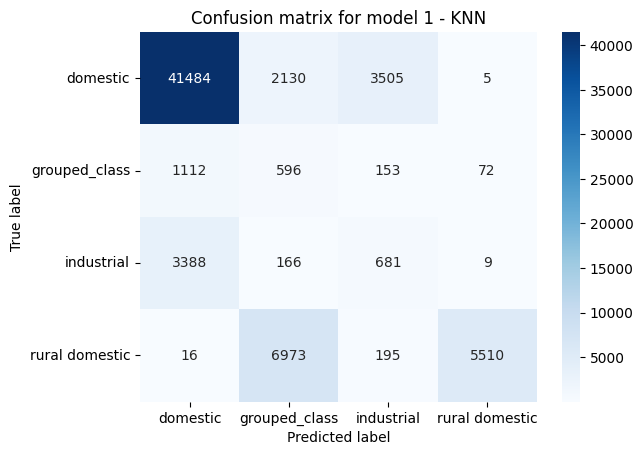

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

x_test_1 = df_test[features_training_1]
y_test_1 = df_test['Consumer_type_group']

y_pred_1 = model.predict(x_test_1)

accuracy_model_1 = accuracy_score(y_test_1, y_pred_1)*100
precision_model_1 = precision_score(y_test_1, y_pred_1, average='weighted')*100
recall_model_1 = recall_score(y_test_1, y_pred_1, average='weighted')*100
f1_model_1 = f1_score(y_test_1, y_pred_1, average='weighted')*100

print('Evaluation metrics for model 1 - KNN:')
print('Accuracy: {:.2f}%'.format(accuracy_model_1))
print('Precision: {:.2f}%'.format(precision_model_1))
print('Recall: {:.2f}%'.format(recall_model_1))
print('F1: {:.2f}%'.format(f1_model_1))

classification_report_1 = classification_report(y_test_1, y_pred_1)
print(classification_report_1)

cm_1 = confusion_matrix(y_test_1, y_pred_1)
sns.heatmap(cm_1, annot=True, cmap='Blues', fmt='g', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion matrix for model 1 - KNN')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation=0)
plt.show()

### 5.2 Model 2 Evaluation - Minor Types Detection

                     precision    recall  f1-score   support

       construction       0.33      0.31      0.32       476
low income families       0.17      0.37      0.24       192
   rural commercial       0.75      0.55      0.64      1069
    rural expansion       0.56      0.86      0.68       196

           accuracy                           0.50      1933
          macro avg       0.46      0.52      0.47      1933
       weighted avg       0.57      0.50      0.52      1933



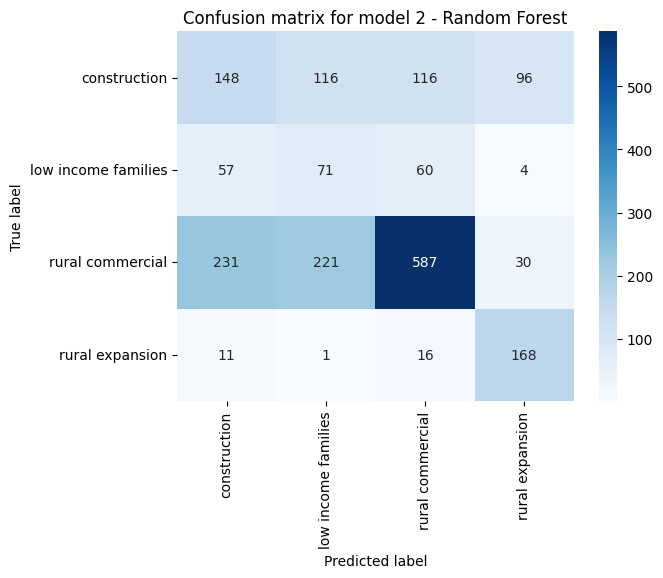

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# filter features for model 2 and consumer type grouped
x_test_2 = df_test.loc[df_test['Consumer_type_group'] == 'grouped_class', features_training_2]
y_test_2 = df_test.loc[df_test['Consumer_type_group'] == 'grouped_class', 'Consumer_type']

y_pred_2 = model_2.predict(x_test_2)

accuracy_model_2 = accuracy_score(y_test_2, y_pred_2)*100
precision_model_2 = precision_score(y_test_2, y_pred_2, average='weighted')*100
recall_model_2 = recall_score(y_test_2, y_pred_2, average='weighted')*100
f1_model_2 = f1_score(y_test_2, y_pred_2, average='weighted')*100

# print('Evaluation metrics for model 2 - Random Forest:')
# print('Accuracy: {:.2f}%'.format(accuracy_model_2))
# print('Precision: {:.2f}%'.format(precision_model_2))
# print('Recall: {:.2f}%'.format(recall_model_2))
# print('F1: {:.2f}%'.format(f1_model_2))

classification_report_2 = classification_report(y_test_2, y_pred_2)
print(classification_report_2)

cm_2 = confusion_matrix(y_test_2, y_pred_2)

sns.heatmap(cm_2, annot=True, cmap='Blues', fmt='g', xticklabels=model_2.classes_, yticklabels=model_2.classes_)
plt.title('Confusion matrix for model 2 - Random Forest')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation=0)
plt.show()

### 5.3 Final Results Evaluation - Types Detection

                     precision    recall  f1-score   support

       construction       0.01      0.01      0.01       476
           domestic       0.90      0.89      0.90     47124
         industrial       0.16      0.14      0.15      4244
low income families       0.00      0.01      0.00       192
   rural commercial       0.20      0.22      0.21      1069
     rural domestic       0.96      0.68      0.80     12694
    rural expansion       0.01      0.27      0.03       196

           accuracy                           0.78     65995
          macro avg       0.32      0.32      0.30     65995
       weighted avg       0.84      0.78      0.81     65995



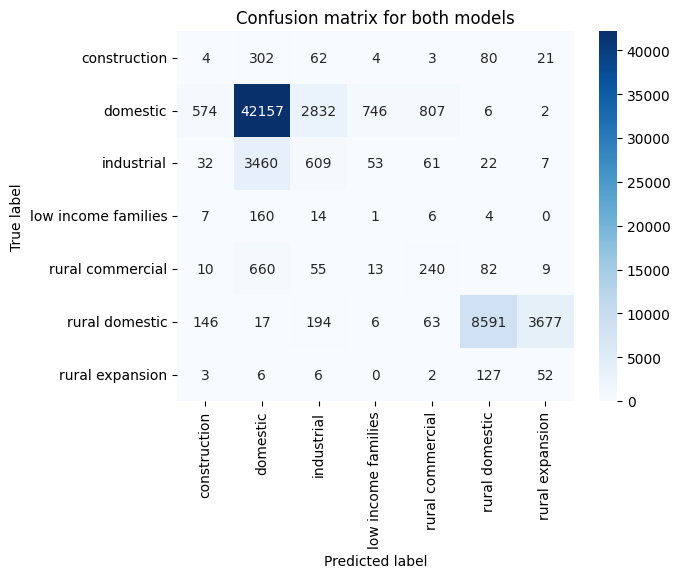

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

def step_model_1(df):
    df = df.copy()
    # Predict the Consumer_type_group
    x_1 = df[features_training_1]
    y_pred_1 = model.predict(x_1)

    df['Consumer_type_group'] = y_pred_1.copy()

    return df

def step_model_2(df):
    df = df.copy()

    # Filter the rows that were predicted as grouped_class
    x_2 = df.loc[df['Consumer_type_group'] == 'grouped_class', features_training_2].copy()
    y_pred_2 = model_2.predict(x_2)

    df['Consumer_type'] = df['Consumer_type_group'].copy()
    df.loc[df['Consumer_type_group'] == 'grouped_class', 'Consumer_type'] = y_pred_2.copy()

    return df

def step_default(df):
    df = df.copy()

    df.loc[df['Consumption'] == 0, 'Consumer_type'] = 'domestic'
    df.loc[(df['Consumption'] == 0) & (df['Installation_zone_group'].isin([4, 5])), 'Consumer_type'] = 'rural domestic'

    return df

def filter_results(df):
    return df['Consumer_type'].copy()

def predict_both_models(df):
    df = df.copy()
    df = step_model_1(df)
    df = step_model_2(df)
    df = step_default(df)
    y_pred = filter_results(df)
    return y_pred

features_test = ['Month','Consumption','Installation_zone_group']
x_test = df_test[features_test]
y_test = df_test['Consumer_type']

y_pred = predict_both_models(x_test)

accuracy_model = accuracy_score(y_test, y_pred)*100
precision_model = precision_score(y_test, y_pred, average='micro')*100
recall_model = recall_score(y_test, y_pred, average='micro')*100
f1_model = f1_score(y_test, y_pred, average='micro')*100

# print('Evaluation metrics for both models:')
# print('Accuracy: {:.2f}%'.format(accuracy_model))
# print('Precision: {:.2f}%'.format(precision_model))
# print('Recall: {:.2f}%'.format(recall_model))
# print('F1: {:.2f}%'.format(f1_model))

classification_report = classification_report(y_test, y_pred)
print(classification_report)


cm = confusion_matrix(y_test, y_pred)

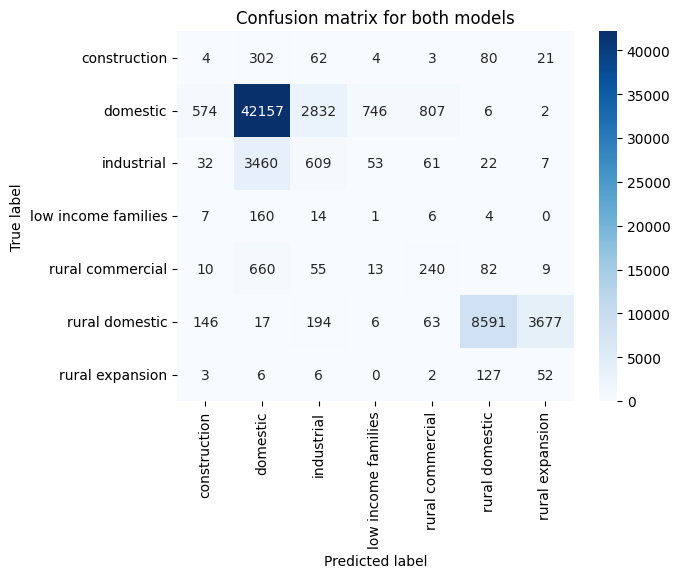

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

labels = sorted(df['Consumer_type'].unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.title('Confusion matrix for both models')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.yticks(rotation=0)
plt.show()

#### Wrong predicted

In [ ]:
df_test_eval = df_test.copy()
df_test_eval['Predicted'] = y_pred

df_test_eval[df_test_eval['Consumer_type'] != df_test_eval['Predicted']]

,Year,Month,Consumer_type,Consumption,Consumer_number,Installation_zone,Consumer_type_group,Installation_zone_group,Predicted
217421,2018,9,domestic,0,LOBY87197135192176,4,domestic,3,industrial
191979,2018,2,rural domestic,0,PSSD56905240495954,5,rural domestic,5,rural expansion
299958,2020,5,rural domestic,0,PRFL59047103628882,46,rural domestic,5,rural expansion
81351,2014,10,domestic,35,XBZC58391604343618,1,domestic,1,industrial
316133,2020,10,construction,0,ROOC45055880892630,2,grouped_class,1,domestic
...,...,...,...,...,...,...,...,...,...
197317,2018,4,domestic,12,RYEH87182113852354,4,domestic,3,industrial
181769,2017,12,industrial,2,EOJZ56932259860930,4,industrial,3,domestic
58112,2014,4,domestic,0,TDCN25309094631976,4,domestic,3,industrial
265756,2019,9,domestic,0,FOAE17462056098295,4,domestic,3,industrial


## 6.0 Predict the Competition file

### 6.1 Preparing data

In [ ]:
import pandas as pd

df_competition = pd.read_csv('src/competition.csv')
df_competition

,Year,Month,Consumption,Consumer_number,Installation_zone
0,2013,1,1,VENX08444954462680,Installation_zone 1
1,2013,1,2,GRXC33020746550125,Installation_zone 1
2,2013,1,1,FCGQ19814303536339,Installation_zone 1
3,2013,1,5,EQKL85694875580467,Installation_zone 3
4,2013,1,14,KCXW91343862250032,Installation_zone 3
...,...,...,...,...,...
18274,2020,12,0,AEQZ48426066915128,Installation_zone 26
18275,2020,12,0,BMPP69449933761787,Installation_zone 17
18276,2020,12,0,XFJB02101108755437,Installation_zone 44
18277,2020,12,0,YRTP25456715504279,Installation_zone 2


In [ ]:
df_competition['Installation_zone'] = df_competition['Installation_zone'].str.extract('(\d+)').astype(int)
df_competition['Installation_zone_group'] = df_competition['Installation_zone'].apply(assign_groups)
df_competition

,Year,Month,Consumption,Consumer_number,Installation_zone,Installation_zone_group
0,2013,1,1,VENX08444954462680,1,1
1,2013,1,2,GRXC33020746550125,1,1
2,2013,1,1,FCGQ19814303536339,1,1
3,2013,1,5,EQKL85694875580467,3,2
4,2013,1,14,KCXW91343862250032,3,2
...,...,...,...,...,...,...
18274,2020,12,0,AEQZ48426066915128,26,5
18275,2020,12,0,BMPP69449933761787,17,5
18276,2020,12,0,XFJB02101108755437,44,5
18277,2020,12,0,YRTP25456715504279,2,1


### 6.2 Predict

In [ ]:
features_competition = ['Month','Consumption','Installation_zone_group']
x_competition = df_competition[features_competition]

y_competition = predict_both_models(x_competition)

df_competition['Consumer_type'] = y_competition
df_competition

,Year,Month,Consumption,Consumer_number,Installation_zone,Installation_zone_group,Consumer_type
0,2013,1,1,VENX08444954462680,1,1,domestic
1,2013,1,2,GRXC33020746550125,1,1,domestic
2,2013,1,1,FCGQ19814303536339,1,1,domestic
3,2013,1,5,EQKL85694875580467,3,2,domestic
4,2013,1,14,KCXW91343862250032,3,2,construction
...,...,...,...,...,...,...,...
18274,2020,12,0,AEQZ48426066915128,26,5,rural domestic
18275,2020,12,0,BMPP69449933761787,17,5,rural domestic
18276,2020,12,0,XFJB02101108755437,44,5,rural domestic
18277,2020,12,0,YRTP25456715504279,2,1,domestic


### 6.3 Save Results

In [ ]:
df_result = df_competition[['Consumer_number','Consumer_type']]
df_result

,Consumer_number,Consumer_type
0,VENX08444954462680,domestic
1,GRXC33020746550125,domestic
2,FCGQ19814303536339,domestic
3,EQKL85694875580467,domestic
4,KCXW91343862250032,construction
...,...,...
18274,AEQZ48426066915128,rural domestic
18275,BMPP69449933761787,rural domestic
18276,XFJB02101108755437,rural domestic
18277,YRTP25456715504279,domestic


In [ ]:
df_result.to_csv('src/resultMultipleModelsRefactored.csv', index=False)

### 6.4 Analytics

<Axes: title={'center': 'Consumer type by installation zone'}, xlabel='Installation_zone'>

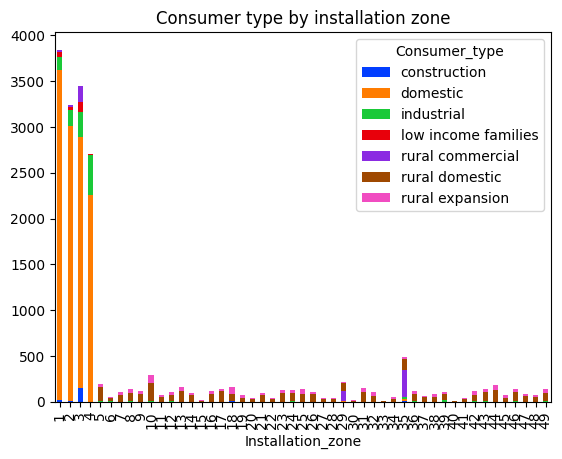

In [ ]:
colors = sns.color_palette('bright', 8)
title = 'Consumer type by installation zone'
df_competition.groupby(['Installation_zone', 'Consumer_type']).size().unstack().plot(kind='bar', stacked=True,color=colors, title=title)